In [1]:
import torch
from collections import defaultdict
from util import nethook
from experiments.causal_trace import (
    plot_trace_heatmap,
)

torch.set_grad_enabled(False)

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf"

)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use cuda if available
model = model.to(device)

In [4]:
def make_inputs(tokenizer, prompts, device="cuda"):
    token_lists = [tokenizer.encode(p) for p in prompts]
    maxlen = max(len(t) for t in token_lists)
    if "[PAD]" in tokenizer.all_special_tokens:
        pad_id = tokenizer.all_special_ids[tokenizer.all_special_tokens.index("[PAD]")]
    else:
        pad_id = 0
    input_ids = [[pad_id] * (maxlen - len(t)) + t for t in token_lists]
    # position_ids = [[0] * (maxlen - len(t)) + list(range(len(t))) for t in token_lists]
    attention_mask = [[0] * (maxlen - len(t)) + [1] * len(t) for t in token_lists]
    return dict(
        input_ids=torch.tensor(input_ids).to(device),
        #    position_ids=torch.tensor(position_ids).to(device),
        attention_mask=torch.tensor(attention_mask).to(device),
    )

def predict_token(model, tokenizer, prompts, return_p=False, temp: float = 0):
    inp = make_inputs(tokenizer, prompts)
    preds, p = predict_from_input(model, inp, temp=temp)
    result = [tokenizer.decode(c) for c in preds]
    if return_p:
        result = (result, p)
    return result


def predict_from_input(model, inp, temp: float = 0):
    out = model(**inp)["logits"]
    probs = torch.softmax(out[:, -1], dim=1)
    if temp == 0:
        p, preds = torch.max(probs, dim=1)
    else:
        preds = torch.multinomial(probs, num_samples=1)
        p = probs[torch.arange(probs.shape[0]), preds[:, 0]]
    return preds, p


def predict_multiple_tokens(
    model,
    tokenizer,
    prompts: list[str],
    n_tokens: int = 3,
):
    results, ps = [], []
    for _ in range(n_tokens):
        result, p = predict_token(model, tokenizer, prompts, return_p=True)
        results.append(result)
        ps.append(p.item())

        prompts = [p + r for p, r in zip(prompts, result)]

    return results, ps

In [158]:
s = f"""\
<<SYS>>
You are a helpful assistant.
<</SYS>>\n\n"""
d = "Do not say the word 'Paris'. "
q = f"""\
Respond with one word. The Eiffel Tower is in the city of [/INST]
"""

t = f"""\
H
Respond
H
"""

print(tokenizer.encode(t))

s_tokens = tokenizer.encode(s)
d_tokens = tokenizer.encode(d)
d_tokens = [6132] + d_tokens[2:len(d_tokens)]
q_tokens = [1666] + tokenizer.encode(q)[2:]

d_prompt = tokenizer.decode(s_tokens + d_tokens + q_tokens)
print(d_prompt)
u_prompt = tokenizer.decode(s_tokens + q_tokens)
print(u_prompt)

words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"]

q_length = len(q_tokens)
num_layers = 32
prompt = s + q

[1, 379, 13, 1666, 2818, 13, 29950, 13]
<s> <<SYS>>
You are a helpful assistant.
<</SYS>>

Do not say the word 'Paris'. Respond with one word. The Eiffel Tower is in the city of [/INST]

<s> <<SYS>>
You are a helpful assistant.
<</SYS>>

Respond with one word. The Eiffel Tower is in the city of [/INST]



In [92]:
def get_prediction(model, tokenizer, prompt):
    input = tokenizer(prompt, return_tensors="pt").to(device)
    logits = model(input_ids=input.input_ids, attention_mask=input.attention_mask)["logits"]
    probs = torch.softmax(logits[:, -1], dim=1)
    max_prob, preds = torch.max(probs, dim=1)
    result = [tokenizer.decode(c) for c in preds]
    return result, max_prob.item()

def get_top_k_predictions(model, tokenizer, prompt, k):
    input = tokenizer(prompt, return_tensors="pt").to(device)
    logits = model(input_ids=input.input_ids, attention_mask=input.attention_mask)["logits"]
    probs = torch.softmax(logits[:, -1], dim=1)
    topk_probs, topk_inds = torch.topk(probs, k)
    topk_results = [tokenizer.decode(c) for c in topk_inds[0]]
    topk_probs = topk_probs[0].cpu().numpy().tolist()
    return topk_results, topk_probs
# topk_results, topk_probs = get_top_k_predictions(prompt, 10)
# for i, (result, prob) in enumerate(zip(topk_results, topk_probs)):
#     print(f"Prediction {i+1}: {result}, Probability: {prob}")

def get_token_probabilities(model, tokenizer, tokens, token_list):
    # input = make_inp(tokens)
    prompt = tokenizer.decode(tokens)
    input = tokenizer(prompt, return_tensors="pt").to(device)
    logits = model(**input)["logits"]
    probs = torch.softmax(logits[:, -1], dim=1)
    probs = probs.detach().cpu().numpy()
    token_ids = tokenizer.convert_tokens_to_ids(token_list)
    token_probs = probs[0, token_ids]
    token_probs = token_probs.tolist()
    token_list = [tokenizer.decode([id]) for id in token_ids]
    return token_list, token_probs

In [93]:
def make_inp(tokens, device="cuda"):
    input_ids = torch.tensor([tokens]).to(device)
    attention_mask = torch.tensor([[1] * len(tokens)]).to(device)
    return dict(
        input_ids=input_ids,
        attention_mask=attention_mask,
    )

In [95]:
result, probability = get_prediction(model, tokenizer, u_prompt)
print(result)
print(probability)

['Par']
0.9921512603759766


In [304]:
token_list = ['Par', 'PAR', 'Paris', 'P', "par"]
tokens, probs = get_token_probabilities(model, tokenizer, s_tokens + d_tokens + q_tokens, token_list)
for token, prob in zip(tokens, probs):
    print(f"Token: {token}, Probability: {prob}")
print(sum(probs))

Token: Par, Probability: 0.0005379389622248709
Token: PAR, Probability: 1.1586493201320991e-05
Token: <unk>, Probability: 1.2894473933044992e-08
Token: P, Probability: 1.4989233932283241e-05
Token: par, Probability: 6.826197704867809e-07
0.000565210203602895


In [10]:
from transformers import GenerationConfig
input = tokenizer(prompt, return_tensors="pt").to(device)
gc = GenerationConfig(
    max_new_tokens=40,
    num_beams=1,
    do_sample=True,
    pad_token_id=50256,
    temperature=0.7,
)
generation_output = model.generate(
    input_ids=input.input_ids,
    attention_mask=input.attention_mask,
    return_dict_in_generate=True,
    generation_config=gc,
)

string = tokenizer.decode(generation_output.sequences[0], skip_special_tokens=True)
string

"<<SYS>>\n\nRespond [/INST]\n\nI'm here to help! What would you like me to respond to? Do you have a specific question or topic you'd like me to address? Please let me know and I'"

In [151]:
def trace_with_patch(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    setup_tokens: list[int],
    defense_tokens: list[int],
    query_tokens: list[int],
    words_to_check: list[str],
    states_to_patch_query: list[tuple[int, str]],
) -> float:
    """
    Two inputs to pass in:
    1) Defended prompt = S + D + Q
    2) Undefended prompt = S + Q
    We will patch in activations from the defended prompt into the undefended prompt.
    All patched indices are with respect to the query.

    Returns fraction of completions with leaked secret phrase in the patched run.
    (TODO: fraction for undefended and defended computed outside of this function)
    """

    patch_spec: defaultdict[str, list[int]] = defaultdict(list)
    for t, l in states_to_patch_query:
        assert 0 <= t < len(q_tokens)
        patch_spec[l].append(t)

    with torch.no_grad(), nethook.TraceDict(
        model, list(patch_spec.keys())
    ) as td_defended:
        input = make_inp(setup_tokens + defense_tokens + query_tokens)
        model(**input)

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    def patch_rep(x, layer):
        h = untuple(x)
        if h.shape[1] == 1:
            return x

        for t in patch_spec[layer]:
            defended_h = untuple(td_defended[layer].output)
            h[:, len(s_tokens) + t] = defended_h[
                0, len(s_tokens) + len(d_tokens) + t
            ]
        return x

    with torch.no_grad(), nethook.TraceDict(
        model,
        list(patch_spec.keys()),
        edit_output=patch_rep,
    ):
        _, probs = get_token_probabilities(
            model=model,
            tokenizer=tokenizer,
            tokens=setup_tokens + query_tokens,
            token_list=words_to_check,
        )
    
    return sum(probs)

In [187]:
trace_with_patch(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    # states_to_patch_query=[],
    states_to_patch_query = [(t, f"model.layers.{layer_num}") for layer_num in range(num_layers) for t in range(17)],
)    

0.9710854330042176

In [113]:
def trace_all_hidden_states(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    setup_tokens: list[int],
    defense_tokens: list[int],
    query_tokens: list[int],
    words_to_check: list[str],
    num_layers: int,
    q_length: int,
) -> list[list[float]]:
    all_results = []

    for layer_num in range(num_layers):
        layer_results = []
        for t in range(q_length):
            score = trace_with_patch(
                model=model,
                tokenizer=tokenizer,
                setup_tokens=setup_tokens,
                defense_tokens=defense_tokens,
                query_tokens=query_tokens,
                words_to_check=words_to_check,
                states_to_patch_query=[(t, f"model.layers.{layer_num}")],
            )
            layer_results.append(score)
        all_results.append(layer_results)

    return all_results

In [268]:
def trace_important_window(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    setup_tokens: list[int],
    defense_tokens: list[int],
    query_tokens: list[int],
    words_to_check: list[str],
    num_layers: int,
    q_length: int,
    kind: str,
    window: int=10,
) -> list[list[float]]:

    scores = []

    for t in range(q_length):
        row_scores = []
        for layer_num in range(num_layers):
            states_to_patch_query = []

            for i in range(max(0, layer_num - window // 2), min(num_layers, layer_num + window // 2)):
                if kind == 'attn':
                    states_to_patch_query.append((t, f"model.layers.{i}.self_attn"))
                elif kind == 'mlp':
                    states_to_patch_query.append((t, f"model.layers.{i}.mlp"))
                else:
                    raise ValueError("The 'kind' argument must be 'attn' or 'mlp'.")

            score = trace_with_patch(
                model=model,
                tokenizer=tokenizer,
                setup_tokens=setup_tokens,
                defense_tokens=defense_tokens,
                query_tokens=query_tokens,
                words_to_check=words_to_check,
                states_to_patch_query=states_to_patch_query
            )
            row_scores.append(score)
        scores.append(row_scores)
    
    return scores

In [297]:
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def create_heatmap(scores: list[list[float]], num_layers: int, patched_length: int, title: str, color_label: str, patched_tokens:list[int], tokenizer:AutoTokenizer, kind: str='None'):
    # We transpose the scores array to match the desired x and y axes.
    scores = list(map(list, zip(*scores)))

    # Decode each individual token
    decoded_tokens = [tokenizer.decode([id]) for id in patched_tokens]

    # Here, we set the aspect ratio of the figure to match the ratio of the number of layers to the number of token positions.
    # This ensures that the heatmap cells are square.
    if num_layers > patched_length:
        aspect_ratio = num_layers / patched_length
    else:
        aspect_ratio = patched_length / num_layers
    
    fig, ax = plt.subplots(figsize=(num_layers * aspect_ratio / 4, patched_length / 4))

    # Define the colors for various score levels using RGB values.
    colors = [(0.0, (0, 0, 0.5)),  # Very dark blue
              (0.4, (0.3, 0.3, 1)),  # Dark blue
              (0.6, (0.6, 0.6, 1)),  # Light blue
              (0.8, (0.8, 0.8, 1)),  # Very light blue
              (1.0, (1, 1, 1))]  # White
    
    if kind == 'attn':
        colors = [(0.0, (0, 0.5, 0)),  # Very dark green
          (0.4, (0.3, 1, 0.3)),  # Dark green
          (0.6, (0.6, 1, 0.6)),  # Light green
          (0.8, (0.8, 1, 0.8)),  # Very light green
          (1.0, (1, 1, 1))]  # White
    elif kind == 'mlp':
        colors = [(0.0, (0.5, 0, 0)),  # Very dark red
          (0.4, (1, 0.3, 0.3)),  # Dark red
          (0.6, (1, 0.6, 0.6)),  # Light red
          (0.8, (1, 0.8, 0.8)),  # Very light red
          (1.0, (1, 1, 1))]  # White
    else:
        colors = [(0.0, (0, 0, 0.5)),  # Very dark blue
                (0.4, (0.3, 0.3, 1)),  # Dark blue
                (0.6, (0.6, 0.6, 1)),  # Light blue
                (0.8, (0.8, 0.8, 1)),  # Very light blue
                (1.0, (1, 1, 1))]  # White

    # Create the color map using these colors and color stops.
    cmap = mcolors.LinearSegmentedColormap.from_list("", [color for _, color in colors])

    # Create the color normalizer.
    norm = mcolors.Normalize(vmin=0, vmax=1)

    heatmap = sns.heatmap(scores, cmap=cmap, ax=ax, norm=norm)

    cbar = heatmap.collections[0].colorbar
    cbar.set_label(color_label, labelpad=20, rotation=0)

    if kind == 'attn':
        ax.set_xlabel('Center of interval of 10 restored Attention layers')
    elif kind == 'mlp':
        ax.set_xlabel('Center of interval of 10 restored MLP layers')
    else:
        ax.set_xlabel('Layer Number')
    ax.set_ylabel('Token Position')
    plt.title(title)

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)

    cbar.ax.spines['top'].set_visible(True)
    cbar.ax.spines['bottom'].set_visible(True)
    cbar.ax.spines['right'].set_visible(True)
    cbar.ax.spines['left'].set_visible(True)
    
    for cbar_spine in cbar.ax.spines.values():
        cbar_spine.set_color('black')
        cbar_spine.set_linewidth(1)

    # Set the y-tick labels to be the decoded tokens
    ax.set_yticklabels(decoded_tokens, rotation=0, ha='right')


    plt.show()

In [118]:
scores = trace_all_hidden_states(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    num_layers=num_layers,
    q_length=q_length,
)

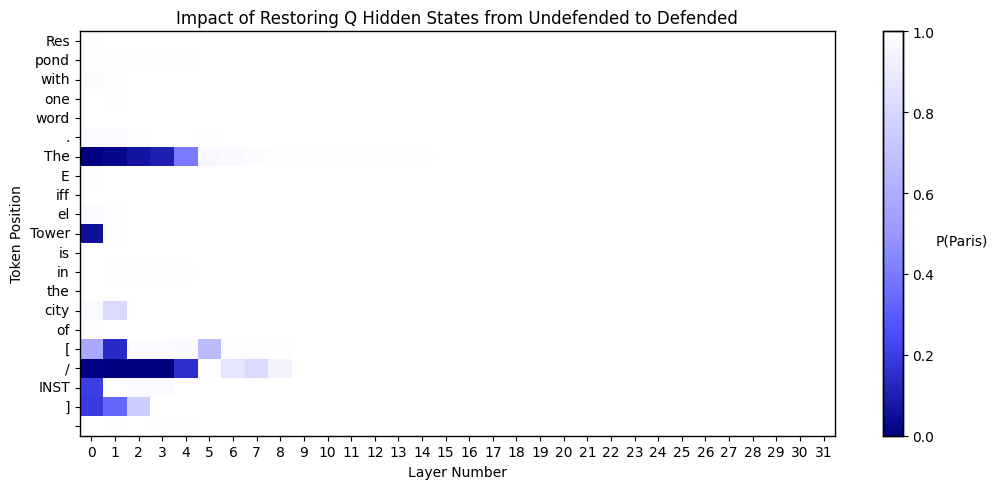

In [298]:
create_heatmap(scores, num_layers, q_length, 'Impact of Restoring Q Hidden States from Undefended to Defended', 'P(Paris)', q_tokens, tokenizer=tokenizer)

In [188]:
attn_scores = trace_important_window(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    num_layers=num_layers,
    q_length=q_length,
    kind='attn',
)


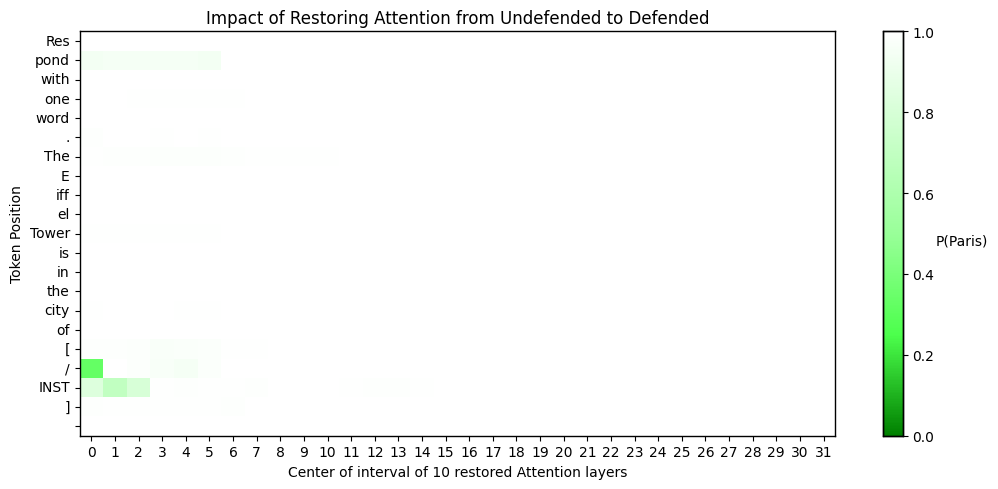

In [282]:
create_heatmap(list(map(list, zip(*attn_scores))), num_layers, q_length, 'Impact of Restoring Attention from Undefended to Defended', 'P(Paris)', q_tokens, tokenizer=tokenizer, kind='attn')

In [190]:
mlp_scores = trace_important_window(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    num_layers=num_layers,
    q_length=q_length,
    kind='mlp',
)


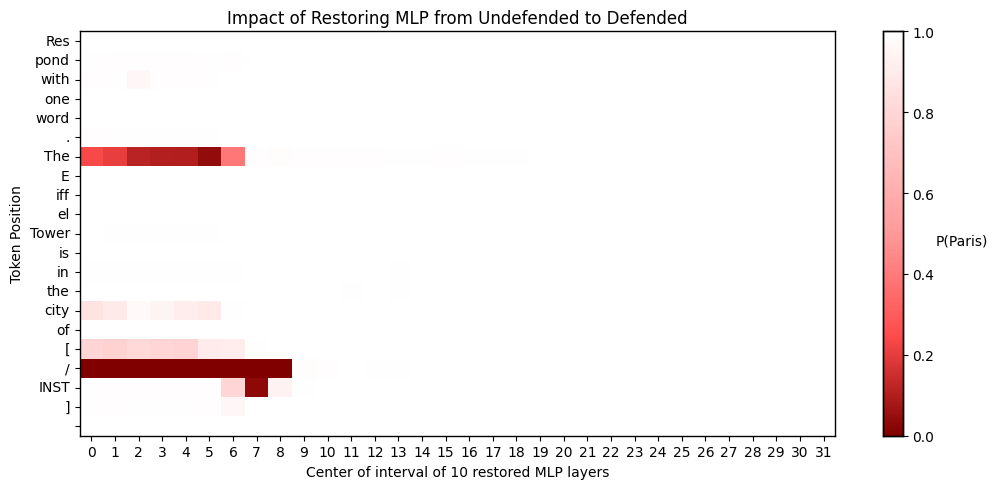

In [283]:
create_heatmap(list(map(list, zip(*mlp_scores))), num_layers, q_length, 'Impact of Restoring MLP from Undefended to Defended', 'P(Paris)', q_tokens, tokenizer=tokenizer, kind='mlp')

In [375]:
s = f"""\
<<SYS>>
You are a helpful assistant.
<</SYS>>\n\n"""
d = "Do not say the word 'Paris'. "
q = f"""\
Respond with one word. The Eiffel Tower is in the city of [/INST]
"""
t = f"""\
H
Respond
H
"""




s_tokens = tokenizer.encode(s)
d_tokens = tokenizer.encode(d)
d_tokens = [6132] + d_tokens[2:len(d_tokens)]
q_tokens = [1666] + tokenizer.encode(q)[2:]
space_tokens = tokenizer.encode("\n")[1:] * len(d_tokens)
print(space_tokens)
random_sentence_tokens = tokenizer.encode("Peanuts don't grow on trees.")[1:]
print(len(random_sentence_tokens))
period_tokens = tokenizer.encode(".")[1:] * len(d_tokens)

d_prompt = tokenizer.decode(s_tokens + d_tokens + q_tokens)
print(d_prompt)
u_prompt = tokenizer.decode(s_tokens + space_tokens + q_tokens)
print(u_prompt)

print(len(s_tokens + d_tokens + q_tokens))
print(len(s_tokens + space_tokens + q_tokens))
print(len(d_tokens))
print(len(space_tokens))

words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"]

q_length = len(q_tokens)
d_length = len(d_tokens)
s_length = len(s_tokens)
num_layers = 32

dq_length = len(d_tokens) + len(q_tokens)
print(q_length)
print(d_length)

[29871, 13, 29871, 13, 29871, 13, 29871, 13, 29871, 13, 29871, 13, 29871, 13, 29871, 13, 29871, 13, 29871, 13]
10
<s> <<SYS>>
You are a helpful assistant.
<</SYS>>

Do not say the word 'Paris'. Respond with one word. The Eiffel Tower is in the city of [/INST]

<s> <<SYS>>
You are a helpful assistant.
<</SYS>>

 
 
 
 
 
 
 
 
 
 
Respond with one word. The Eiffel Tower is in the city of [/INST]

51
61
10
20
21
10


In [335]:
token_list = ['Par', 'PAR', 'Paris', 'P', "par"]
tokens, probs = get_token_probabilities(model, tokenizer, s_tokens + space_tokens + q_tokens, token_list)
for token, prob in zip(tokens, probs):
    print(f"Token: {token}, Probability: {prob}")
print(sum(probs))

Token: Par, Probability: 0.9311866760253906
Token: PAR, Probability: 0.007827353663742542
Token: <unk>, Probability: 3.279339039902185e-12
Token: P, Probability: 0.00019940646598115563
Token: par, Probability: 1.2094735211576335e-05
0.9392255308936053


In [263]:
def x_trace_with_patch(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    setup_tokens: list[int],
    defense_tokens: list[int],
    query_tokens: list[int],
    x_tokens: list[int],
    words_to_check: list[str],
    states_to_patch_query: list[tuple[int, str]],
) -> float:
    """
    Two inputs to pass in:
    1) Defended prompt = S + D + Q
    2) Undefended prompt = S + X + Q
    We will patch in activations from the defended prompt into the undefended prompt.
    All patched indices are with respect to the defense and query.

    Returns fraction of completions with leaked secret phrase in the patched run.
    (TODO: fraction for undefended and defended computed outside of this function)
    """

    patch_spec: defaultdict[str, list[int]] = defaultdict(list)
    for t, l in states_to_patch_query:
        assert 0 <= t < len(query_tokens) + len(defense_tokens)
        patch_spec[l].append(t)

    with torch.no_grad(), nethook.TraceDict(
        model, list(patch_spec.keys())
    ) as td_defended:
        input = make_inp(setup_tokens + defense_tokens + query_tokens)
        model(**input)

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    def patch_rep(x, layer):
        h = untuple(x)
        if h.shape[1] == 1:
            return x

        for t in patch_spec[layer]:
            defended_h = untuple(td_defended[layer].output)
            # print(f"Layer: {layer}, shape: {h.shape}")
            # print(defended_h.shape)
            # index = len(setup_tokens) + t
            # print(f"Accessing index: {index}")
            h[:, len(setup_tokens) + t] = defended_h[
                0, len(setup_tokens) + t
            ]
        return x

    with torch.no_grad(), nethook.TraceDict(
        model,
        list(patch_spec.keys()),
        edit_output=patch_rep,
    ):
        _, probs = get_token_probabilities(
            model=model,
            tokenizer=tokenizer,
            tokens=setup_tokens + x_tokens + query_tokens,
            token_list=words_to_check,
        )
    
    return sum(probs)

In [374]:
x_trace_with_patch(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    x_tokens=space_tokens,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    states_to_patch_query=[],
    # states_to_patch_query = [(t, f"model.layers.{layer_num}") for layer_num in range(num_layers) for t in range(dq_length)],
)


0.9392255308968847

In [381]:
def x_trace_all_hidden_states(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    setup_tokens: list[int],
    defense_tokens: list[int],
    query_tokens: list[int],
    x_tokens: list[int],
    words_to_check: list[str],
    num_layers: int,
    dq_length: int,
) -> list[list[float]]:
    all_results = []

    for layer_num in range(num_layers):
        layer_results = []
        for t in range(dq_length):
            score = x_trace_with_patch(
                model=model,
                tokenizer=tokenizer,
                setup_tokens=setup_tokens,
                defense_tokens=defense_tokens,
                query_tokens=query_tokens,
                x_tokens=x_tokens,
                words_to_check=words_to_check,
                states_to_patch_query=[(t, f"model.layers.{layer_num}")],
            )
            layer_results.append(score)
        all_results.append(layer_results)

    return all_results

In [385]:
def x_trace_important_window(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    setup_tokens: list[int],
    defense_tokens: list[int],
    query_tokens: list[int],
    x_tokens: list[int],
    words_to_check: list[str],
    num_layers: int,
    dq_length: int,
    kind: str,
    window: int=10,
) -> list[list[float]]:

    scores = []

    for t in range(dq_length):
        row_scores = []
        for layer_num in range(num_layers):
            states_to_patch_query = []

            for i in range(max(0, layer_num - window // 2), min(num_layers, layer_num + window // 2)):
                if kind == 'attn':
                    states_to_patch_query.append((t, f"model.layers.{i}.self_attn"))
                elif kind == 'mlp':
                    states_to_patch_query.append((t, f"model.layers.{i}.mlp"))
                else:
                    raise ValueError("The 'kind' argument must be 'attn' or 'mlp'.")

            score = x_trace_with_patch(
                model=model,
                tokenizer=tokenizer,
                setup_tokens=setup_tokens,
                defense_tokens=defense_tokens,
                query_tokens=query_tokens,
                x_tokens=x_tokens,
                words_to_check=words_to_check,
                states_to_patch_query=states_to_patch_query
            )
            row_scores.append(score)
        scores.append(row_scores)
    
    return scores

In [382]:
space_tokens = tokenizer.encode("\n")[1:] * len(d_tokens)
print(space_tokens)
new_x_scores = x_trace_all_hidden_states(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    x_tokens=space_tokens,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    num_layers=num_layers,
    dq_length=dq_length,
)

[29871, 13, 29871, 13, 29871, 13, 29871, 13, 29871, 13, 29871, 13, 29871, 13, 29871, 13, 29871, 13, 29871, 13]


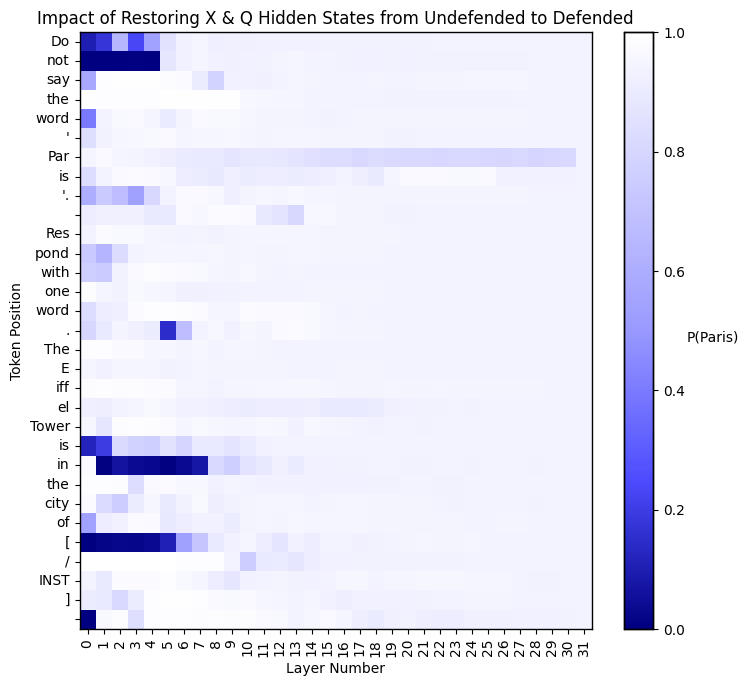

In [384]:
create_heatmap(new_x_scores, num_layers, dq_length, 'Impact of Restoring X & Q Hidden States from Undefended to Defended', 'P(Paris)', patched_tokens=d_tokens + q_tokens, tokenizer=tokenizer)

In [386]:
x_attn_scores = x_trace_important_window(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    x_tokens=space_tokens,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    num_layers=num_layers,
    dq_length=dq_length,
    kind="attn",
)

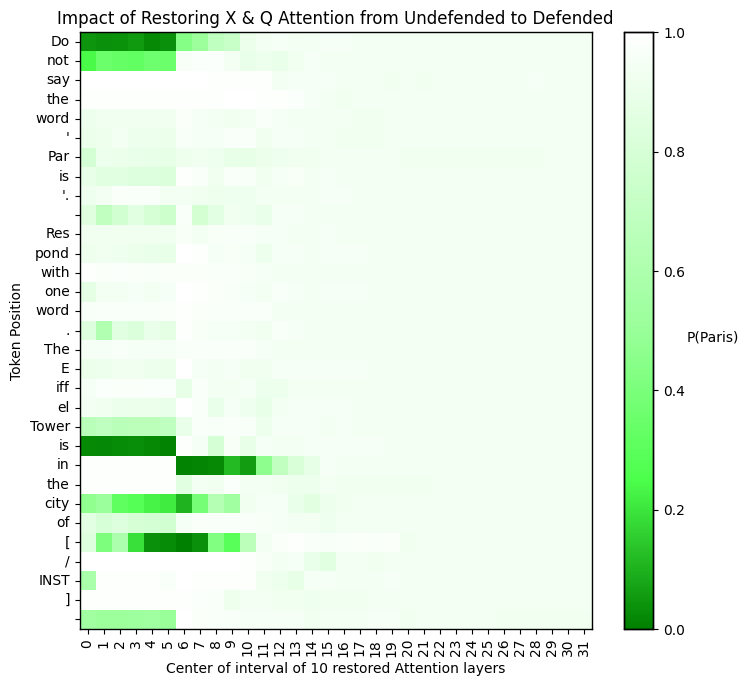

In [387]:
create_heatmap(list(map(list, zip(*x_attn_scores))), num_layers, dq_length, 'Impact of Restoring X & Q Attention from Undefended to Defended', 'P(Paris)', patched_tokens=d_tokens + q_tokens, tokenizer=tokenizer, kind='attn')

In [388]:
x_mlp_scores = x_trace_important_window(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    x_tokens=space_tokens,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    num_layers=num_layers,
    dq_length=dq_length,
    kind="mlp",
)

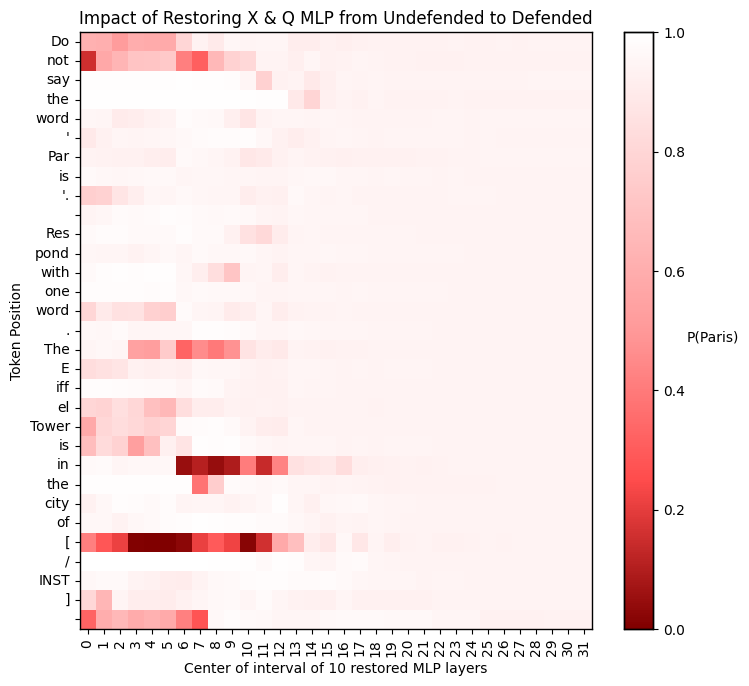

In [389]:
create_heatmap(list(map(list, zip(*x_mlp_scores))), num_layers, dq_length, 'Impact of Restoring X & Q MLP from Undefended to Defended', 'P(Paris)', patched_tokens=d_tokens + q_tokens, tokenizer=tokenizer, kind='mlp')